# SQL Analysis with Chinook
*Focus: Window Functions · Aggregate Filtering (HAVING) · Business Insights*

**Project context:** Uncovering trends and performance metrics to inform marketing and catalog decisions. The Chinook database contains data on customers, invoices, tracks, albums, artists, and genres. 

### Top customers based on total purchases, and how do they compare to the average customer?
- **Plan:** Use SUM(), GROUP BY, and a HAVING clause to find high-value customers.
- **Skills:** Aggregation, HAVING, Sorting

*“This query helps identify VIP customers for potential loyalty or referral campaigns.”*

**Process:**
- Initially, I calculated the average per order, but this overlooked that customers may have placed multiple orders.
- Next, I summed total purchases per customer, computed the average across all customers, and experimented with different result limits.
- *Key insight:* All customers spent over €35, while the average total spent per customer is approximately €39.

**Visualization:**
- The bar plot below shows the top 20 customers ranked by total purchases.
- The red dashed line indicates the average total purchases per customer, providing a visual benchmark for comparison.

In [20]:
# Download all necessary libraries and connect to the database
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Download the Chinook database here:
# https://github.com/lerocha/chinook-database
# Connect to the database
conn = sqlite3.connect('Chinook_dataset.sqlite')


In [21]:
# Query 1 : Identify top customers compared to the average spent per customer 
query_top_customers = '''
WITH sum_total AS 
(SELECT CustomerID, SUM(Total) as total_spent FROM Invoice GROUP BY CustomerID),
avg_total AS(
SELECT AVG(total_spent) as avg_spent_per_customer FROM sum_total)
SELECT 
c.FirstName ||' ' || c.LastName as CustomerName, 
s.total_spent , (Select avg_spent_per_customer FROM avg_total) as avg_spent_per_customer
FROM Customer c JOIN sum_total s on c.CustomerID = s.CustomerID
ORDER BY total_spent DESC
LIMIT 20;  
'''
df_top_customers = pd.read_sql_query(query_top_customers, conn) 

C:\Users\Teo\AppData\Local\Temp\ipykernel_13008\381530520.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




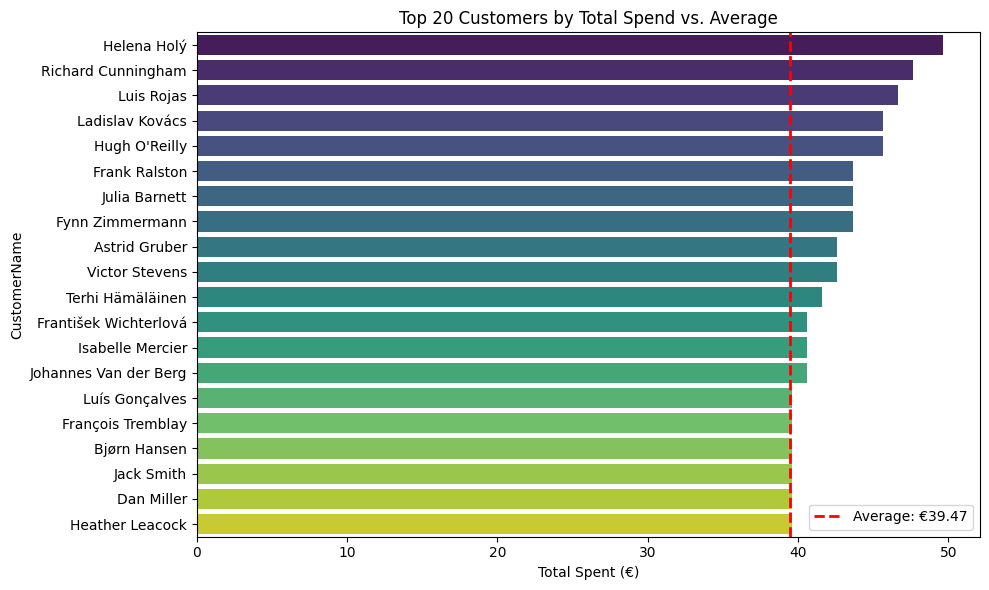

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_top_customers,
    x='total_spent',
    y='CustomerName',
    palette='viridis' 
)

average = df_top_customers['avg_spent_per_customer'].iloc[0]
plt.axvline(average, color='red', linestyle='--', linewidth=2,
            label=f'Average: €{average:.2f}')

plt.xlabel('Total Spent (€)')
plt.title('Top 20 Customers by Total Spend vs. Average')
plt.legend()
plt.tight_layout()
plt.show()



### Which albums generate the most revenue, and how do they rank within the artist’s full catalog?
- **Plan:** Calculate album revenue (via track unit price), and use RANK() or DENSE_RANK() over each artist’s albums.
- **Skills:** Window Functions, JOINs, Aggregation

*“Useful for contract renegotiations or artist-focused marketing — reveals which albums are driving income per artist.”*

**Process:** 
- I first calculated revenue per album and ranked albums within each artist using SQL window functions.

- Then I identified the top 20 albums overall by revenue to highlight high performers.

- Finally, I summed revenue per artist to find the top 20 highest-earning artists.

**Visualizations:**

- The first plot shows the top 3 albums by revenue per artist (for a sample of 4 artists), demonstrating how revenue is distributed within an artist’s catalog.

- The second plot highlights the top 20 individual albums by revenue, revealing the biggest revenue drivers.

- The third plot summarizes total revenue by artist, showing the most commercially successful artists in the dataset.



In [23]:
# Query 2: Album revenue with rank within each artist
query_ranked_albums = '''
WITH AlbumRevenue AS (
    SELECT 
        a.AlbumId,
        a.Title,
        ar.Name AS ArtistName,
        SUM(il.Quantity * il.UnitPrice) AS RevenuePerAlbum
    FROM Track t
    JOIN InvoiceLine il ON t.TrackId = il.TrackId
    JOIN Album a ON a.AlbumId = t.AlbumId
    JOIN Artist ar ON a.ArtistId = ar.ArtistId
    GROUP BY a.AlbumId
)
SELECT
    AlbumId,
    Title,
    ArtistName,
    RevenuePerAlbum,
    RANK() OVER (PARTITION BY ArtistName ORDER BY RevenuePerAlbum DESC) AS AlbumRank
FROM AlbumRevenue
ORDER BY ArtistName, AlbumRank;
'''
df_ranked_albums = pd.read_sql_query(query_ranked_albums, conn)

# Query 3: Top 20 albums by revenue
query_top_albums = '''
SELECT 
    a.Title,
    ar.Name AS ArtistName,
    SUM(il.Quantity * il.UnitPrice) AS RevenuePerAlbum
FROM Track t
JOIN InvoiceLine il ON t.TrackId = il.TrackId
JOIN Album a ON a.AlbumId = t.AlbumId
JOIN Artist ar ON a.ArtistId = ar.ArtistId
GROUP BY a.AlbumId
ORDER BY RevenuePerAlbum DESC
LIMIT 20;
'''
df_top_albums = pd.read_sql_query(query_top_albums, conn)

# Query 4: Top 20 artists by total revenue
query_top_artists = '''
SELECT 
    ar.Name AS ArtistName,
    SUM(il.Quantity * il.UnitPrice) AS RevenuePerArtist
FROM Track t
JOIN InvoiceLine il ON t.TrackId = il.TrackId
JOIN Album a ON a.AlbumId = t.AlbumId
JOIN Artist ar ON a.ArtistId = ar.ArtistId
GROUP BY ar.ArtistId
ORDER BY RevenuePerArtist DESC
LIMIT 20;
'''
df_top_artists = pd.read_sql_query(query_top_artists, conn)



In [24]:
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display

# Ensure numeric rank
df_ranked_albums['AlbumRank'] = pd.to_numeric(df_ranked_albums['AlbumRank'])

# Dropdown of artist names
artist_dropdown = widgets.Dropdown(
    options=sorted(df_ranked_albums['ArtistName'].unique()),
    description='Artist:',
)

def plot_artist(artist_name):
    sub = (df_ranked_albums.query("ArtistName == @artist_name")
                           .sort_values("AlbumRank"))
    fig = px.bar(
    sub,
    x='RevenuePerAlbum',
    y='Title',
    orientation='h',
    color='AlbumRank',
    color_continuous_scale='viridis',
    labels={'RevenuePerAlbum': 'Revenue (€)', 'Title': 'Album'},
    title=f'Album Revenue Ranking – {artist_name}'
)
    fig.update_layout(
        yaxis_categoryorder = 'total ascending',
        coloraxis_showscale=False
        )
    fig.show()


widgets.interact(plot_artist, artist_name=artist_dropdown);

interactive(children=(Dropdown(description='Artist:', options=('AC/DC', 'Academy of St. Martin in the Fields &…

C:\Users\Teo\AppData\Local\Temp\ipykernel_13008\3252317535.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




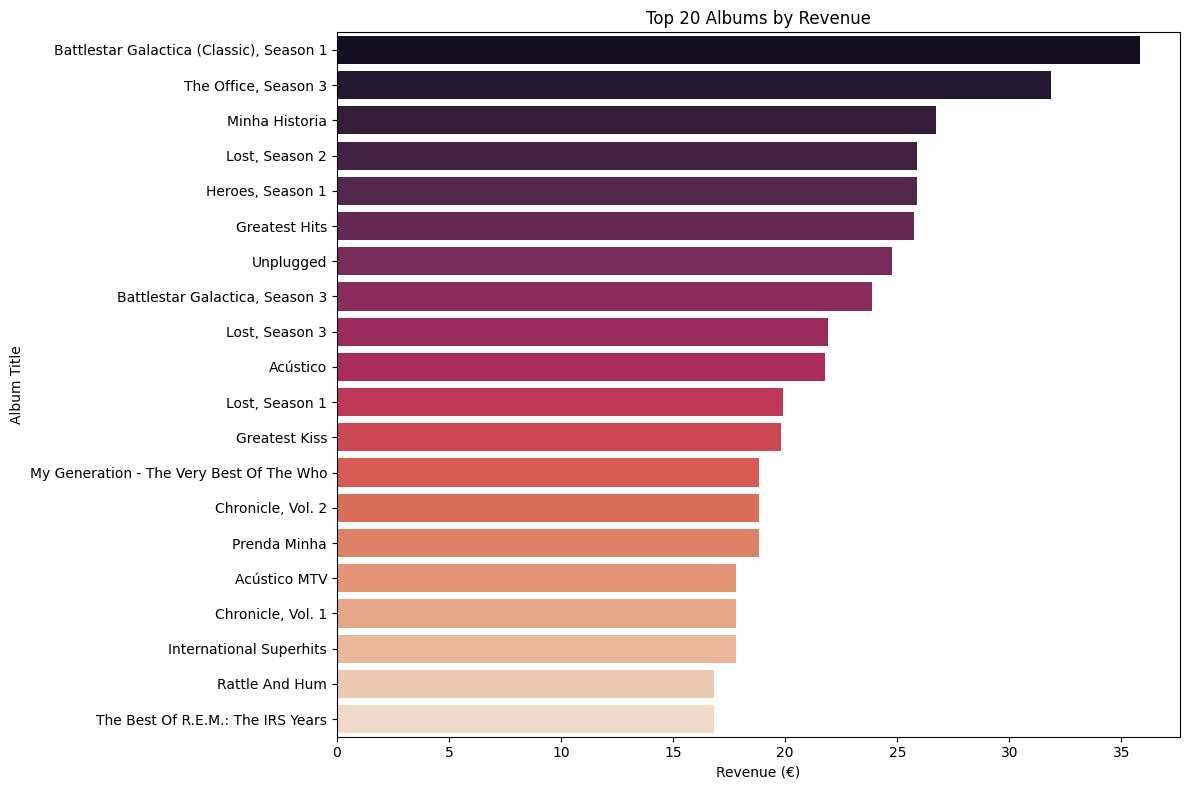

In [25]:

# Plot 2: Top 20 albums by revenue
plt.figure(figsize=(12, 8))
sns.barplot(
    data=df_top_albums.sort_values('RevenuePerAlbum', ascending=False),
    y='Title',
    x='RevenuePerAlbum',
    palette='rocket'
)
plt.title('Top 20 Albums by Revenue')
plt.xlabel('Revenue (€)')
plt.ylabel('Album Title')
plt.tight_layout()
plt.show()

C:\Users\Teo\AppData\Local\Temp\ipykernel_13008\37890417.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




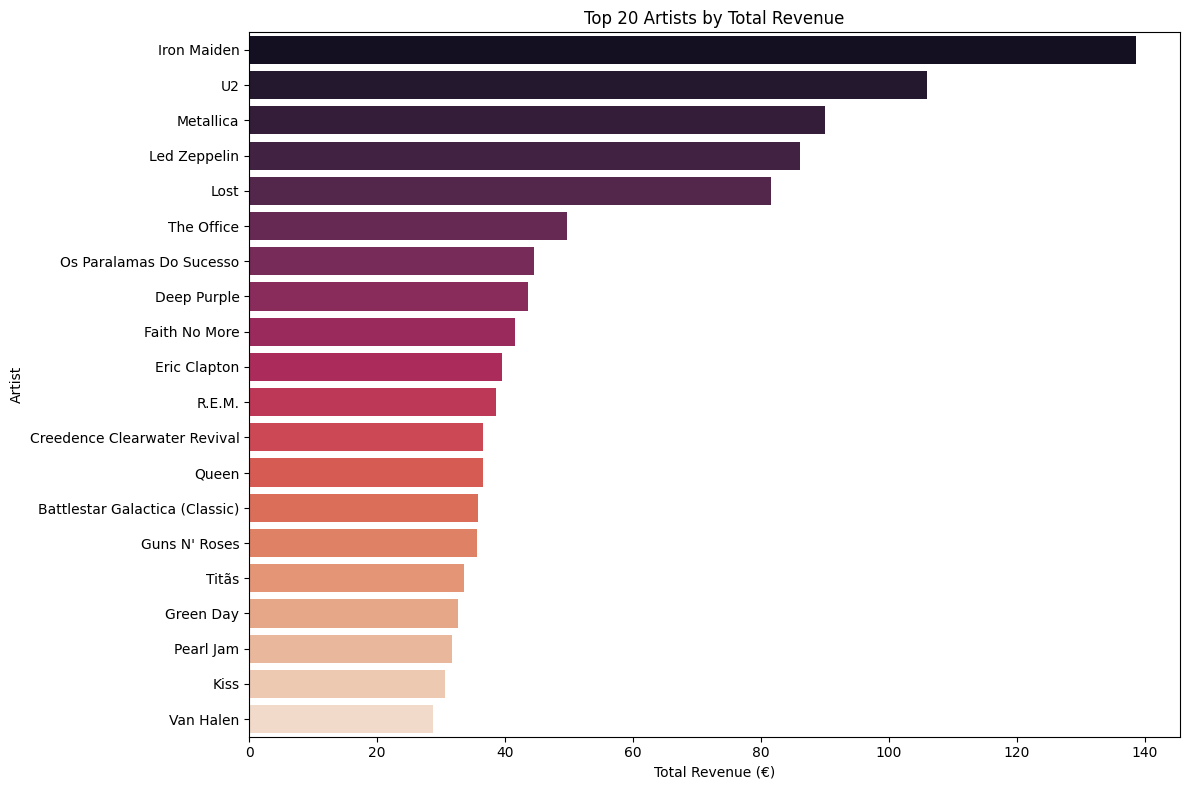

In [26]:


# Plot 3: Top 20 artists by total revenue
plt.figure(figsize=(12, 8))
sns.barplot(
    data=df_top_artists.sort_values('RevenuePerArtist', ascending=False),
    y='ArtistName',
    x='RevenuePerArtist',
    palette='rocket'
)
plt.title('Top 20 Artists by Total Revenue')
plt.xlabel('Total Revenue (€)')
plt.ylabel('Artist')
plt.tight_layout()
plt.show()



## A cross-country exploration of preferences and profitability
**Plan:** Use JOINs and GROUP BY to calculate revenue per genre. Identify commercially successful genres regionally/

**Skills:** Aggregation, joining multiple tables, data summarization

*This query helps identify the most commercially successful genres, enabling smarter investment in future catalog development and marketing initiatives* 

**Process and Visualizations:**
- Chart 1: **Top Purchased Genre per Country** (Bar Plot — One Genre per Country):

This bar chart gives us a high-level overview by showing the top-selling genre per country, based on purchase counts. It allows quick comparison across countries, identifying where certain genres dominate — for example, Latin music might be leading in Latin American markets, while Rock might be most purchased in North America or Europe.

**Business takeaway:** Helps target marketing by aligning genre promotions with dominant regional preferences.

- Chart 2: **Revenue Share by Genre Within Country** (Pie Chart — Interactive by Country):

This interactive pie chart allows us to dive into individual country profiles, highlighting which genres contribute most to revenue in that specific market. Unlike purchase counts, this view incorporates pricing differences, revealing if fewer purchases still result in higher revenue.

**Business takeaway:** Informs pricing strategy and bundling — if Classical generates high revenue from few sales, maybe it's priced as a premium offering.

- Chart 3: **Purchase Distribution per Genre Across Countries** (Bar Plot — Interactive by Genre)

Here we flip the lens: Instead of countries, we start from a genre and see which countries are driving its popularity. This is valuable for genre-specific campaigns, music licensing deals, or regional artist promotion.

**Business takeaway:** If Electronic music is booming in Scandinavian countries but underperforming elsewhere, there's opportunity to scale targeted content or offers.

- Chart 4: **Popularity vs Profitability of Genres** (Scatter Plot — Bubble Size = Avg. Revenue per Purchase)

This scatter plot compares genres by how often they’re purchased (x-axis) and how much revenue they generate (y-axis), with bubble size representing average revenue per purchase.

We observe four zones:

Top right: Popular and profitable (e.g., Latin, Rock)

Bottom right: Popular but low-value per purchase (e.g., Pop)

Top left: Niche but high-margin genres (e.g., TV Shows, Jazz)

Bottom left: Low revenue and popularity — potentially oversupplied or underpromoted genres

**Business takeaway:** Supports product portfolio strategy — identify which genres to push more, bundle, discount, or rethink entirely.

Together, these four charts create a multi-dimensional view of our music catalog.


In [27]:
# Query 5: Revenues per genre per country
query_genres_percountry = '''
SELECT SUM(il.Quantity*il.UnitPrice) as Revenues, g.name as Genre, i.BillingCountry as Country, Count(*) as PurchaseCount 
FROM InvoiceLine il
JOIN Track t ON il.TrackId = t.TrackId
JOIN Album a ON a.albumID = t.AlbumId
JOIN Genre g ON g.GenreId = t.GenreId
JOIN Invoice i ON i.InvoiceId = il.InvoiceId 
GROUP BY Genre, Country
Order BY Country;'''

df_genres_percountry = pd.read_sql_query(query_genres_percountry, conn)

# Query 6: The most popular genres in each country
query_top_genres = '''
With GenreCounts AS (
SELECT g.name as Genre, i.BillingCountry as Country, Count(*) as PurchaseCount 
FROM InvoiceLine il
JOIN Track t ON il.TrackId = t.TrackId
JOIN Album a ON a.albumID = t.AlbumId
JOIN Genre g ON g.GenreId = t.GenreId
JOIN Invoice i ON i.InvoiceId = il.InvoiceLineId 
GROUP BY Genre, Country),
TopGenresPerCountry AS (
SELECT *,
RANK() OVER (Partition BY Country ORDER BY PurchaseCount DESC) AS GenreRank
FROM GenreCounts)
SELECT Genre, Country, PurchaseCount
FROM TopGenresPerCountry
WHERE GenreRank = 1
ORDER BY Country;
'''
df_top_genres = pd.read_sql_query(query_top_genres, conn)

query_revenues_pergenre = '''SELECT SUM(il.Quantity*il.UnitPrice) as Revenues, g.name as Genre, Count(*) as PurchaseCount 
FROM InvoiceLine il
JOIN Track t ON il.TrackId = t.TrackId
JOIN Album a ON a.albumID = t.AlbumId
JOIN Genre g ON g.GenreId = t.GenreId
JOIN Invoice i ON i.InvoiceId = il.InvoiceId 
GROUP BY Genre
ORDER BY Revenues;'''

df_revenues_pergenre = pd.read_sql_query(query_revenues_pergenre, conn)

In [28]:
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

# Dropdown widget for genre selection
genre_dropdown = widgets.Dropdown(
    options=sorted(df_genres_percountry['Genre'].unique()),
    description='Genre:',
    layout=widgets.Layout(width='50%')
)

# Define the function to update the plot
def plot_by_genre(selected_genre):
    plt.figure(figsize=(10, 8))

    # Filter by selected genre
    df_filtered = df_genres_percountry[df_genres_percountry['Genre'] == selected_genre]

    # Sort for visual clarity
    df_filtered = df_filtered.sort_values(['Country', 'PurchaseCount'], ascending=[True, False])

    sns.barplot(
        data=df_filtered,
        x='PurchaseCount',
        y='Country',
        hue='Genre',
        dodge=False,
        palette='viridis'
    )

    plt.title(f'Purchases of Genre "{selected_genre}" by Country', fontsize=14)
    plt.xlabel('Number of Purchases')
    plt.ylabel('Country')
    plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Use interact to link dropdown to plot
widgets.interact(plot_by_genre, selected_genre=genre_dropdown)


interactive(children=(Dropdown(description='Genre:', layout=Layout(width='50%'), options=('Alternative', 'Alte…

<function __main__.plot_by_genre(selected_genre)>

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets

# Dropdown widget for country selection
country_dropdown = widgets.Dropdown(
    options=sorted(df_genres_percountry['Country'].unique()),
    description='Country:',
    layout=widgets.Layout(width='50%')
)

# Plotting function
def plot_country_genres(selected_country):
    df_country = df_genres_percountry[df_genres_percountry['Country'] == selected_country]
    df_country = df_country.sort_values('Revenues', ascending=False)

    # Prepare labels with genre and revenue for clarity
    labels = [f"{genre} (€{revenue:,.0f})" for genre, revenue in zip(df_country['Genre'], df_country['Revenues'])]

    plt.figure(figsize=(7, 7))
    plt.pie(
        df_country['Revenues'],
        labels=labels,
        autopct='%1.1f%%',
        startangle=140,
        colors=plt.cm.viridis_r(np.linspace(0, 1, len(df_country)))
    )
    plt.title(f"Revenue Share by Genre – {selected_country}", fontsize=14)
    plt.tight_layout()
    plt.show()

# Display interactive widget
widgets.interact(plot_country_genres, selected_country=country_dropdown)


interactive(children=(Dropdown(description='Country:', layout=Layout(width='50%'), options=('Argentina', 'Aust…

<function __main__.plot_country_genres(selected_country)>

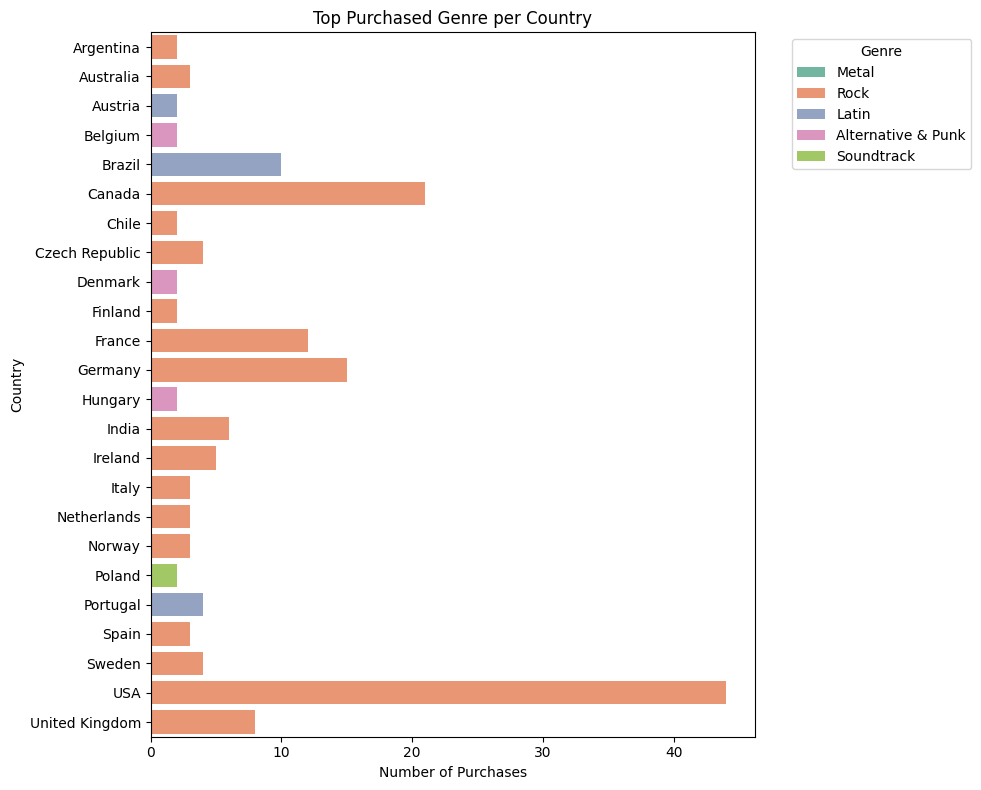

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.barplot(
    data=df_top_genres,  # <- your query result
    x='PurchaseCount',
    y='Country',
    hue='Genre',
    dodge=False,
    palette='Set2'
)

plt.title('Top Purchased Genre per Country')
plt.xlabel('Number of Purchases')
plt.ylabel('Country')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


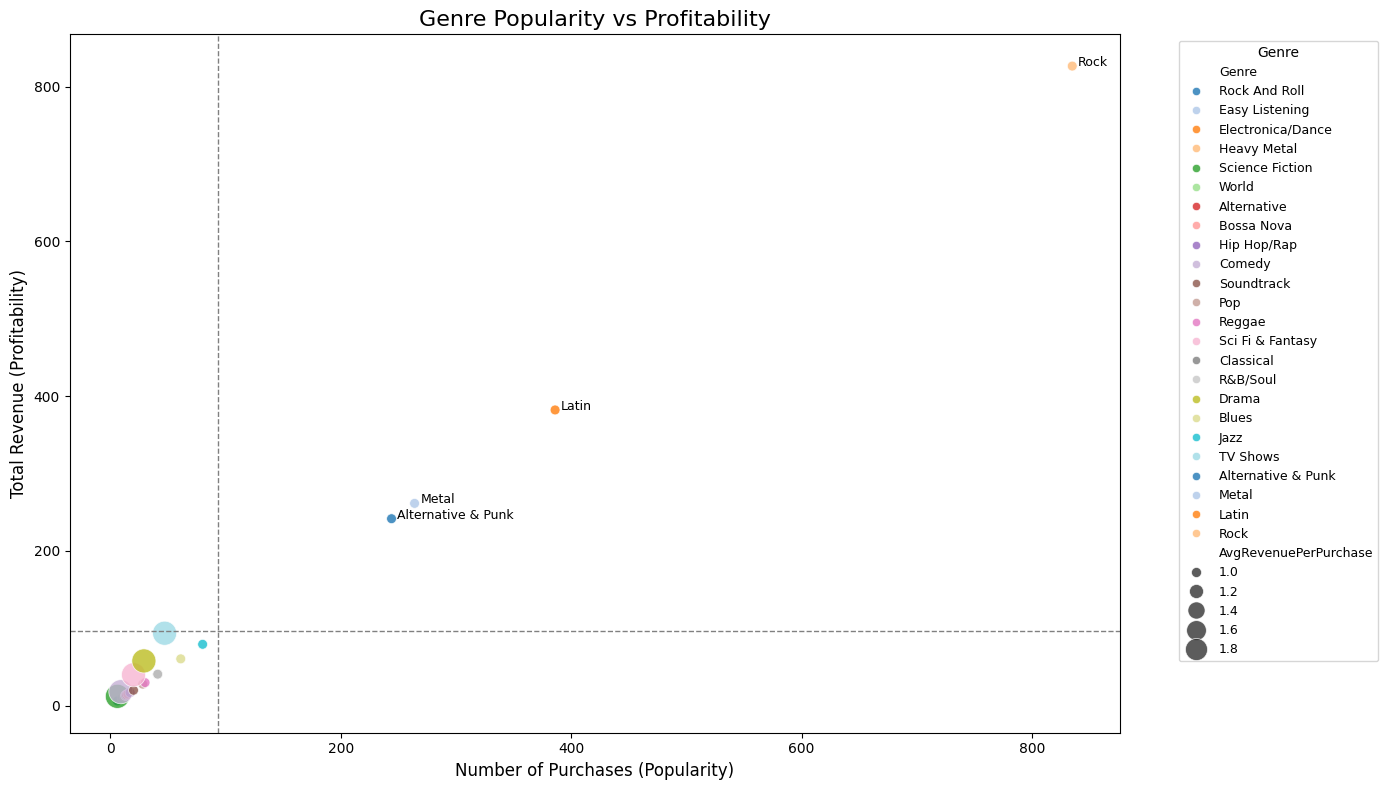

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate average revenue per purchase (optional for bubble size)
df_revenues = df_revenues_pergenre.copy()
df_revenues['AvgRevenuePerPurchase'] = df_revenues['Revenues'] / df_revenues['PurchaseCount']

# Create figure
plt.figure(figsize=(14, 8))

# Scatterplot with size representing avg revenue per purchase
sns.scatterplot(
    data=df_revenues,
    x='PurchaseCount',
    y='Revenues',
    hue='Genre',
    size='AvgRevenuePerPurchase',
    sizes=(50, 300),
    palette='tab20',
    alpha=0.8,
    legend='brief'
)

# Add text labels (only for genres above thresholds to reduce clutter)
for i, row in df_revenues.iterrows():
    if row['Revenues'] > 100 or row['PurchaseCount'] > 100:
        plt.text(row['PurchaseCount'] + 5, row['Revenues'], row['Genre'], fontsize=9)

# Add mean reference lines
plt.axvline(df_revenues['PurchaseCount'].mean(), color='gray', linestyle='--', linewidth=1)
plt.axhline(df_revenues['Revenues'].mean(), color='gray', linestyle='--', linewidth=1)

# Titles and labels
plt.title("Genre Popularity vs Profitability", fontsize=16)
plt.xlabel("Number of Purchases (Popularity)", fontsize=12)
plt.ylabel("Total Revenue (Profitability)", fontsize=12)

# Adjust legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Genre', fontsize=9)

# Layout fix
plt.tight_layout()
plt.show()


